Input data shape: (11605, 66)
Output data shape: (11605, 3228)
Batch 1 (Training)
Inputs: torch.Size([32, 66])
Targets: torch.Size([32, 3228])


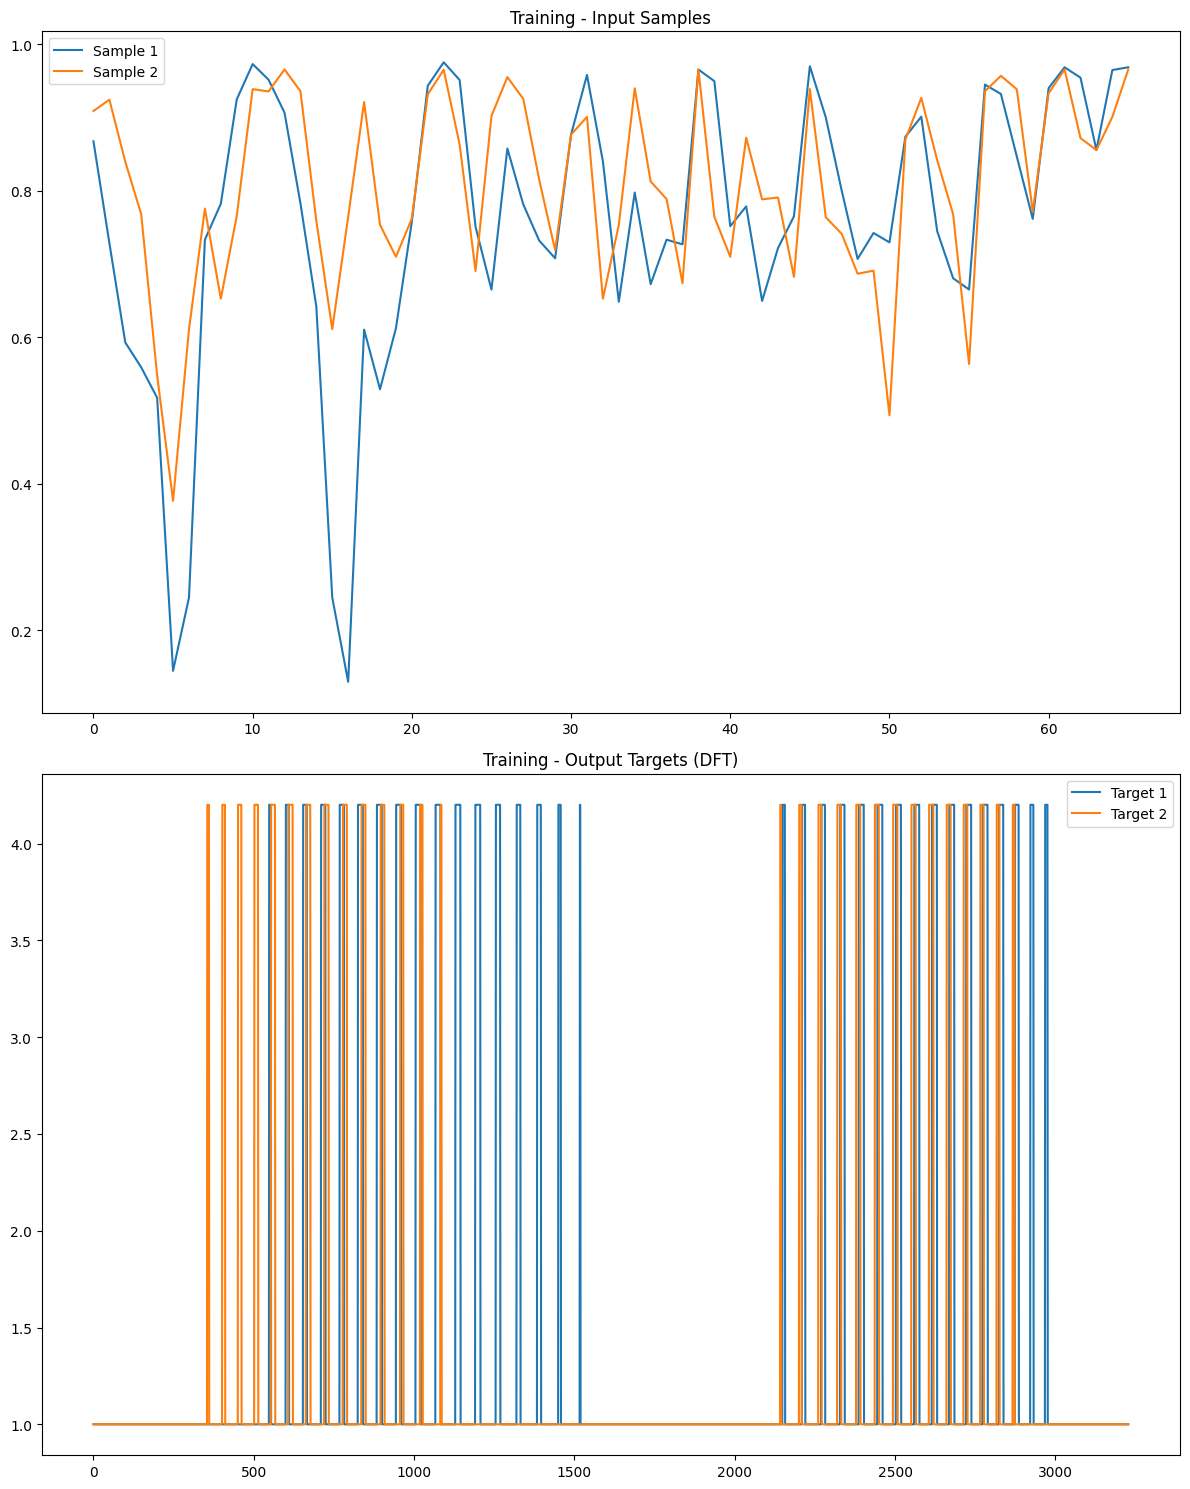

Batch 1 (Testing)
Inputs: torch.Size([32, 66])
Targets: torch.Size([32, 3228])


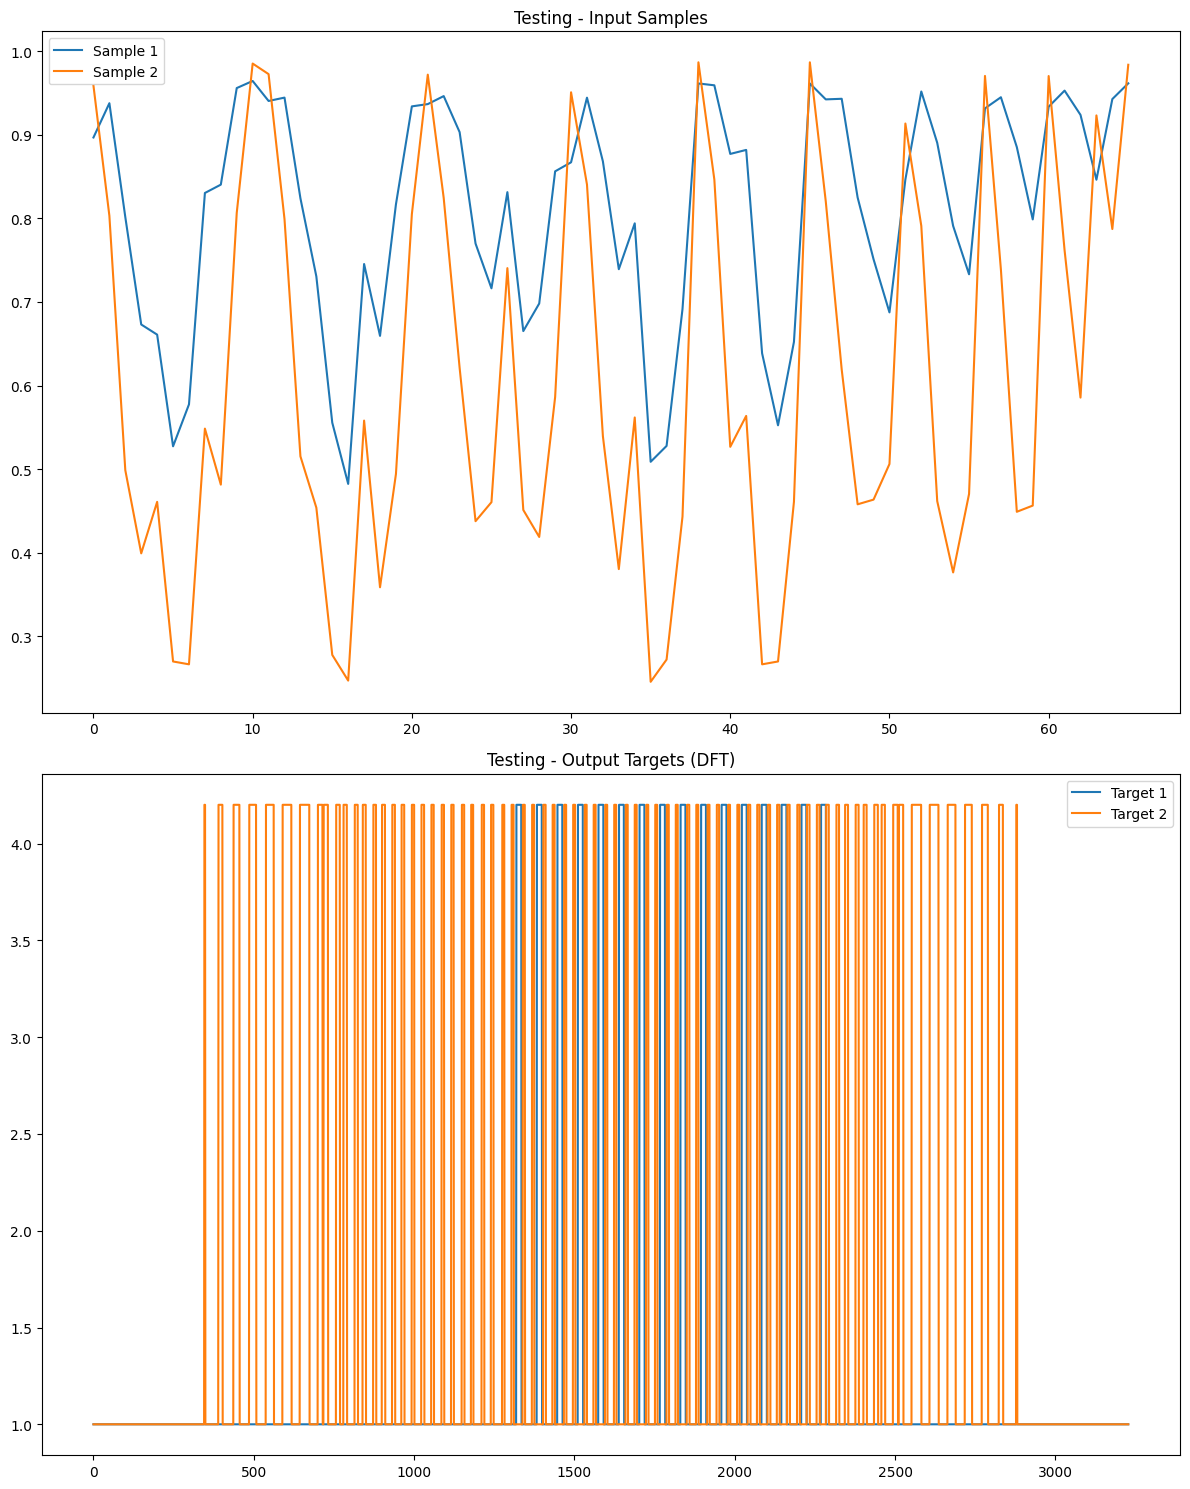

Expected input size: [32, 66]
Example training input size: torch.Size([32, 66])
Example testing input size: torch.Size([32, 66])


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Read input and output data from CSV files
input_file_path = '/kaggle/input/capacitance-dataset/C2.csv'
output_file_path = '/kaggle/input/capacitance-dataset/G2.csv'

input_data = pd.read_csv(input_file_path, header=None)
output_data = pd.read_csv(output_file_path, header=None)

# Print the shapes of the input and output data
print(f"Input data shape: {input_data.shape}")
print(f"Output data shape: {output_data.shape}")

# Normalize input data to the range [0, 1]
scaler_input = MinMaxScaler(feature_range=(0, 1))
input_data_scaled = scaler_input.fit_transform(input_data)

# Split the dataset into training and testing sets
input_train, input_test, output_train, output_test = train_test_split(input_data_scaled, output_data, test_size=0.2, random_state=42)

# Convert output data to numpy arrays
output_train = np.array(output_train)
output_test = np.array(output_test)

# Convert data to PyTorch tensors
input_train_tensor = torch.tensor(input_train, dtype=torch.float32)
output_train_tensor = torch.tensor(output_train, dtype=torch.float32)
input_test_tensor = torch.tensor(input_test, dtype=torch.float32)
output_test_tensor = torch.tensor(output_test, dtype=torch.float32)

# Create TensorDataset objects for training and testing datasets
train_dataset = TensorDataset(input_train_tensor, output_train_tensor)
test_dataset = TensorDataset(input_test_tensor, output_test_tensor)

# Create DataLoader objects to load data in batches
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to visualize input samples and their corresponding targets
def plot_samples(inputs, targets, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 15))

    # Plot the first two input samples
    axes[0].plot(inputs[0].cpu().numpy(), label='Sample 1')
    axes[0].plot(inputs[1].cpu().numpy(), label='Sample 2')
    axes[0].set_title(f'{title} - Input Samples')
    axes[0].legend()

    # Plot the corresponding targets for the first two input samples
    axes[1].plot(targets[0].cpu().numpy(), label='Target 1')
    axes[1].plot(targets[1].cpu().numpy(), label='Target 2')
    axes[1].set_title(f'{title} - Output Targets (DFT)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Check the DataLoader and display a sample batch
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx+1} (Training)")
    print(f"Inputs: {inputs.size()}")
    print(f"Targets: {targets.size()}")
    plot_samples(inputs, targets, "Training")
    if batch_idx == 0:
        break  # Only display the first batch

for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx+1} (Testing)")
    print(f"Inputs: {inputs.size()}")
    print(f"Targets: {targets.size()}")
    plot_samples(inputs, targets, "Testing")
    if batch_idx == 0:
        break  # Only display the first batch

# Ensure data dimensions are as expected
print(f"Expected input size: {[batch_size, input_train.shape[1]]}")
print(f"Example training input size: {next(iter(train_loader))[0].size()}")
print(f"Example testing input size: {next(iter(test_loader))[0].size()}")


# one way CNN-LSTM-Attention

In [3]:
import torch
import torch.nn as nn

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Attention(nn.Module):
    def __init__(self, lstm_units):
        super(Attention, self).__init__()
        # Define the attention mechanism as a sequential model
        self.attention = nn.Sequential(
            nn.Linear(lstm_units, 128),  # Linear layer to project LSTM output
            nn.ReLU(True),  # ReLU activation
            nn.Linear(128, 1)  # Linear layer to produce attention weights
        )

    def forward(self, lstm_output):
        # Compute attention weights
        attention_weights = self.attention(lstm_output)
        attention_weights = torch.softmax(attention_weights, dim=1)  # Apply softmax to get probabilities
        # Compute the context vector as a weighted sum of LSTM outputs
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector, attention_weights

class CNN1DModelWithLSTMAndAttention(nn.Module):
    def __init__(self, input_size, num_classes, lstm_units, conv_filters, fc_units):
        super(CNN1DModelWithLSTMAndAttention, self).__init__()
        
        # Define 1D convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_filters[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_filters[0], out_channels=conv_filters[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=conv_filters[1], out_channels=conv_filters[2], kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=conv_filters[2], out_channels=conv_filters[3], kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=conv_filters[3], out_channels=conv_filters[4], kernel_size=3, padding=1)
        
        # Define batch normalization layers
        self.bn1 = nn.BatchNorm1d(conv_filters[0])
        self.bn2 = nn.BatchNorm1d(conv_filters[1])
        self.bn3 = nn.BatchNorm1d(conv_filters[2])
        self.bn4 = nn.BatchNorm1d(conv_filters[3])
        self.bn5 = nn.BatchNorm1d(conv_filters[4])
        
        # Define activation function
        self.relu = nn.ReLU()
        
        # Define max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Calculate the output size after convolution and pooling layers
        conv_output_size = input_size // (2**5)  # Size reduced by a factor of 2 for each of the 5 pooling layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=(conv_filters[4] * conv_output_size), hidden_size=lstm_units, batch_first=True)
        
        # Define attention mechanism
        self.attention = Attention(lstm_units)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(lstm_units, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        self.fc3 = nn.Linear(fc_units[1], num_classes)
        
        # Define dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        
        # Flatten the output for LSTM input
        x = x.view(x.size(0), -1)

        # Pass through LSTM layer
        x, _ = self.lstm(x.unsqueeze(1))  # Add time step dimension

        # Apply attention mechanism
        context_vector, attention_weights = self.attention(x)
        
        # Pass through fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(context_vector))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define model parameters
input_size = 66  # Number of input features
num_classes = 3228  # Number of output features

lstm_units = 32  # Number of LSTM units
conv_filters = [8, 16, 32, 64, 128]  # Number of filters in convolutional layers
fc_units = [512, 256]  # Number of units in fully connected layers

# Create model instance
model = CNN1DModelWithLSTMAndAttention(input_size, num_classes, lstm_units, conv_filters, fc_units).to(device)

# Create a sample input tensor for testing
batch_size = 32
example_input = torch.randn(batch_size, 1, input_size).to(device)

# Perform a forward pass
output = model(example_input)

# Print input and output shapes
print(f"Input tensor shape: {example_input.shape}")
print(f"Output tensor shape: {output.shape}")


Input tensor shape: torch.Size([32, 1, 66])
Output tensor shape: torch.Size([32, 3228])


In [6]:
from torchinfo import summary

# Display model summary using torchinfo
summary(model, input_size=(batch_size, 1, input_size))


Layer (type:depth-idx)                   Output Shape              Param #
CNN1DModelWithLSTMAndAttention           [32, 3228]                --
├─Conv1d: 1-1                            [32, 8, 66]               32
├─BatchNorm1d: 1-2                       [32, 8, 66]               16
├─ReLU: 1-3                              [32, 8, 66]               --
├─MaxPool1d: 1-4                         [32, 8, 33]               --
├─Conv1d: 1-5                            [32, 16, 33]              400
├─BatchNorm1d: 1-6                       [32, 16, 33]              32
├─ReLU: 1-7                              [32, 16, 33]              --
├─MaxPool1d: 1-8                         [32, 16, 16]              --
├─Conv1d: 1-9                            [32, 32, 16]              1,568
├─BatchNorm1d: 1-10                      [32, 32, 16]              64
├─ReLU: 1-11                             [32, 32, 16]              --
├─MaxPool1d: 1-12                        [32, 32, 8]               --
├─Conv1d: 1

In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def initialization(SearchAgents_no, dim, ub, lb):
    """
    Initialize the positions of search agents within the given bounds.
    
    Parameters:
    SearchAgents_no (int): Number of search agents.
    dim (int): Dimension of the search space.
    ub (list or array): Upper bounds of the search space.
    lb (list or array): Lower bounds of the search space.
    
    Returns:
    Positions (array): Initialized positions of search agents.
    """
    Boundary_no = len(ub)
    Positions = np.zeros((SearchAgents_no, dim))
    
    if Boundary_no == 1:
        # If all dimensions have the same bounds
        Positions = np.random.rand(SearchAgents_no, dim) * (ub - lb) + lb
    else:
        # If each dimension has different bounds
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            Positions[:, i] = np.random.rand(SearchAgents_no) * (ub_i - lb_i) + lb_i
    return Positions

def CPO(Pop_size, Tmax, lb, ub, dim, fobj):
    """
    Execute the Crested Porcupine Optimizer algorithm.
    
    Parameters:
    Pop_size (int): Population size (number of search agents).
    Tmax (int): Maximum number of iterations.
    lb (list or array): Lower bounds of the search space.
    ub (list or array): Upper bounds of the search space.
    dim (int): Dimension of the search space.
    fobj (function): Objective function to be minimized.
    
    Returns:
    Gb_Fit (float): Best fitness value found.
    Gb_Sol (array): Best solution found.
    Conv_curve (array): Convergence curve of the best fitness value over iterations.
    """
    Conv_curve = np.zeros(Tmax)  # Array to store the best fitness value at each iteration
    ub = np.array(ub)
    lb = np.array(lb)
    
    X = initialization(Pop_size, dim, ub, lb)  # Initialize the positions of search agents
    t = 0  # Iteration counter
    
    # Evaluate the fitness of initial positions
    fitness = np.array([fobj(X[i, :]) for i in range(Pop_size)])
    Gb_Fit = np.min(fitness)  # Best fitness value
    Gb_Sol = X[np.argmin(fitness), :]  # Best solution
    
    Xp = X.copy()  # Copy of the current positions
    
    # Optimization loop
    with tqdm(total=Tmax, desc='CPO Optimization', unit='iter') as pbar:
        while t < Tmax:
            for i in range(Pop_size):
                U1 = np.random.rand(dim) > np.random.rand()
                if np.random.rand() < np.random.rand():
                    if np.random.rand() < np.random.rand():
                        y = (X[i, :] + X[np.random.randint(Pop_size), :]) / 2
                        X[i, :] = X[i, :] + (np.random.randn() * abs(2 * np.random.rand() * Gb_Sol - y))
                    else:
                        y = (X[i, :] + X[np.random.randint(Pop_size), :]) / 2
                        X[i, :] = (U1 * X[i, :]) + ((1 - U1) * (y + np.random.rand() * (X[np.random.randint(Pop_size), :] - X[np.random.randint(Pop_size), :])))
                else:
                    Yt = 2 * np.random.rand() * (1 - t / Tmax) ** (t / Tmax)
                    U2 = (np.random.rand(dim) < 0.5) * 2 - 1
                    S = np.random.rand() * U2
                    if np.random.rand() < 0.8:
                        St = np.exp(fitness[i] / (np.sum(fitness) + np.finfo(float).eps))
                        S = S * Yt * St
                        X[i, :] = (1 - U1) * X[i, :] + U1 * (X[np.random.randint(Pop_size), :] + St * (X[np.random.randint(Pop_size), :] - X[np.random.randint(Pop_size), :]) - S)
                    else:
                        Mt = np.exp(fitness[i] / (np.sum(fitness) + np.finfo(float).eps))
                        vt = X[i, :]
                        Vtp = X[np.random.randint(Pop_size), :]
                        Ft = np.random.rand(dim) * (Mt * (-vt + Vtp))
                        S = S * Yt * Ft
                        X[i, :] = Gb_Sol + 0.2 * (1 - np.random.rand()) + np.random.rand() * (U2 * Gb_Sol - X[i, :]) - S
                
                # Ensure the positions are within the bounds
                X[i, :] = np.clip(X[i, :], lb, ub)
                nF = fobj(X[i, :])  # Evaluate the fitness of the new position
                if fitness[i] < nF:
                    X[i, :] = Xp[i, :]
                else:
                    Xp[i, :] = X[i, :]
                    fitness[i] = nF
                    if fitness[i] <= Gb_Fit:
                        Gb_Sol = X[i, :]
                        Gb_Fit = fitness[i]
                        
            t += 1
            Conv_curve[t - 1] = Gb_Fit  # Update the convergence curve
            pbar.set_postfix({'Best Fitness': Gb_Fit, 'Iteration': t})
            pbar.update(1)
        pbar.close()
    
    return Gb_Fit, Gb_Sol, Conv_curve

def fobj(params):
    """
    Objective function for hyperparameter optimization of a neural network.
    
    Parameters:
    params (array): Array of hyperparameters to be optimized.
    
    Returns:
    test_loss (float): Average test loss of the neural network with the given hyperparameters.
    """
    # Extract hyperparameters from the params array
    lstm_units = int(params[0])
    conv_filters_1 = int(params[1])
    conv_filters_2 = int(params[2])
    conv_filters_3 = int(params[3])
    conv_filters_4 = int(params[4])
    conv_filters_5 = int(params[5])
    fc_units_1 = int(params[6])
    fc_units_2 = int(params[7])
    learning_rate = params[8]
    
    conv_filters = [conv_filters_1, conv_filters_2, conv_filters_3, conv_filters_4, conv_filters_5]
    fc_units = [fc_units_1, fc_units_2]
    
    # Define the model with the given hyperparameters
    model = CNN1DModelWithLSTMAndAttention(input_size, num_classes, lstm_units, conv_filters, fc_units).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'Optimization Epoch {epoch+1}/{num_epochs} (Training)', unit='batch')
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)  # Add channel dimension
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_bar.set_postfix({'Loss': loss.item()})
        train_bar.close()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Validation (Testing)', unit='batch')
        for X_batch, y_batch in test_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)  # Add channel dimension
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_bar.set_postfix({'Loss': loss.item()})
        test_bar.close()
    
    return test_loss / len(test_loader)

# CPO algorithm parameters
Pop_size = 10
Tmax = 10
dim = 9  # Number of hyperparameters to optimize
lb = [10, 16, 16, 16, 16, 16, 50, 50, 0.00001]  # Lower bounds of hyperparameters
ub = [512, 128, 128, 128, 128, 128, 2048, 1024, 0.001]  # Upper bounds of hyperparameters

# Use CPO to optimize hyperparameters
Best_fit, Best_sol, Conv_curve = CPO(Pop_size, Tmax, lb, ub, dim, fobj)
clear_output(wait=True)
print(f"Best parameters found: {Best_sol}")

# Plot the convergence curve
plt.figure()
plt.plot(Conv_curve)
plt.title('Convergence Curve')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.grid()
plt.show()


Optimization Epoch 1/10 (Training):  22%|██▏       | 63/291 [00:02<00:08, 26.18batch/s, Loss=1.04] 


KeyboardInterrupt: 

# Train it with non-opted network (Control)

In [8]:
import os
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import datetime
import pandas as pd

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with initial parameters
model = CNN1DModelWithLSTMAndAttention(input_size, num_classes, lstm_units, conv_filters, fc_units).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Define R2 score function
def r2_score(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_true_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2.item()

# Record losses and R2 scores during training and testing
train_losses = []
train_r2_scores = []
test_losses = []
test_r2_scores = []

# Get current time and create a folder for saving results
current_time = datetime.datetime.now().strftime("%m%d%H%M")
folder_name = f"origin_model_{current_time}"
os.makedirs(folder_name, exist_ok=True)

# Train the model
num_epochs = 200  # Number of epochs for training

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_r2 = 0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for X_batch, y_batch in train_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r2 += r2_score(y_batch, outputs)
        train_bar.set_postfix(loss=train_loss/len(train_bar), r2=train_r2/len(train_bar))
    
    train_losses.append(train_loss / len(train_loader))
    train_r2_scores.append(train_r2 / len(train_loader))
    
    model.eval()
    test_loss = 0
    test_r2 = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Validation', unit='batch')
        for X_batch, y_batch in test_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)  # Add channel dimension

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_r2 += r2_score(y_batch, outputs)
            test_bar.set_postfix(loss=test_loss/len(test_bar), r2=test_r2/len(test_bar))
    
    test_losses.append(test_loss / len(test_loader))
    test_r2_scores.append(test_r2 / len(test_loader))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train R2: {train_r2/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test R2: {test_r2/len(test_loader):.4f}')

# Save the training and validation loss and R2 score to CSV file
history_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train R2': train_r2_scores,
    'Test Loss': test_losses,
    'Test R2': test_r2_scores
})
history_df.to_csv(os.path.join(folder_name, 'training_history.csv'), index=False)

# Plot and save the loss and R2 score curves
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_r2_scores, label='Train R2')
plt.plot(range(1, num_epochs+1), test_r2_scores, label='Test R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('R2 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_r2_curve.png'))  # Save to file
plt.show()

# Predict and visualize results on the test set
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == 0:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            
            # Move inputs, predictions, and targets to CPU for visualization
            inputs = inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            
            # Visualize actual and predicted results
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))

            # Randomly select a sample for visualization
            sample_idx = random.randint(0, inputs.shape[0] - 1)
            axes[0].plot(targets[sample_idx], label='Actual')
            axes[0].set_title('Actual Output')
            axes[0].legend()

            axes[1].plot(outputs[sample_idx], label='Predicted')
            axes[1].set_title('Predicted Output')
            axes[1].legend()

            # Overlay of actual and predicted outputs
            axes[2].plot(targets[sample_idx], label='Actual', alpha=0.7)
            axes[2].plot(outputs[sample_idx], label='Predicted', alpha=0.7)
            axes[2].set_title('Overlay of Actual and Predicted Output')
            axes[2].legend()

            plt.savefig(os.path.join(folder_name, 'actual_vs_predicted.png'))  # Save to file
            plt.show()
            break

# Compute final R2 score on the test set
model.eval()
final_test_r2 = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        outputs = model(X_batch)
        final_test_r2 += r2_score(y_batch, outputs)

final_test_r2 /= len(test_loader)
print(f"Final Test R2: {final_test_r2:.4f}")

# Save the model
model_name = f"{model.__class__.__name__}_R2_{final_test_r2:.4f}_{current_time}_VANILLA.pt"
torch.save(model.state_dict(), os.path.join(folder_name, model_name))
print(f"Model saved as {os.path.join(folder_name, model_name)}")

# Predict on the test set and save results
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())

# Convert predictions to numpy array
predictions = np.vstack(predictions)

# Save predictions to CSV file
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(os.path.join(folder_name, 'predictions.csv'), index=False)

print(f"Predictions saved to {os.path.join(folder_name, 'predictions.csv')}")


Epoch 1/200:  57%|█████▋    | 165/291 [00:03<00:02, 45.80batch/s, loss=0.612, r2=0.0416]   


KeyboardInterrupt: 

# Train it with the Best Params

In [9]:
import os
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import datetime
import pandas as pd

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read the best parameters from CSV file
best_params_path = '/kaggle/input/best-params/best_parameters.csv' # your path to the params.csv
# if you don't want to extract the best params, just source it from input space: /kaggle/input/best-params/best_parameters.csv
best_params_df = pd.read_csv(best_params_path)
best_params = best_params_df.iloc[0].values

# Extract the best parameters
lstm_units = int(best_params[0])
conv_filters = [int(best_params[1]), int(best_params[2]), int(best_params[3]), int(best_params[4]), int(best_params[5])]
fc_units = [int(best_params[6]), int(best_params[7])]

# Initialize the model with the best parameters
model = CNN1DModelWithLSTMAndAttention(input_size, num_classes, lstm_units, conv_filters, fc_units).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Define R2 score function
def r2_score(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_true_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2.item()

# Record losses and R2 scores during training and testing
train_losses = []
train_r2_scores = []
test_losses = []
test_r2_scores = []

# Get current time and create a folder for saving results
current_time = datetime.datetime.now().strftime("%m%d%H%M")
folder_name = f"CPO_model_{current_time}"
os.makedirs(folder_name, exist_ok=True)

# Train the model
num_epochs = 200  # Number of epochs for training

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_r2 = 0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for X_batch, y_batch in train_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r2 += r2_score(y_batch, outputs)
        train_bar.set_postfix(loss=train_loss/len(train_bar), r2=train_r2/len(train_bar))
    
    train_losses.append(train_loss / len(train_loader))
    train_r2_scores.append(train_r2 / len(train_loader))
    
    model.eval()
    test_loss = 0
    test_r2 = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Validation', unit='batch')
        for X_batch, y_batch in test_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)  # Add channel dimension

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_r2 += r2_score(y_batch, outputs)
            test_bar.set_postfix(loss=test_loss/len(test_bar), r2=test_r2/len(test_bar))
    
    test_losses.append(test_loss / len(test_loader))
    test_r2_scores.append(test_r2 / len(test_loader))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train R2: {train_r2/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test R2: {test_r2/len(test_loader):.4f}')

# Save the training and validation loss and R2 score to CSV file
history_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train R2': train_r2_scores,
    'Test Loss': test_losses,
    'Test R2': test_r2_scores
})
history_df.to_csv(os.path.join(folder_name, 'training_history_CPO.csv'), index=False)

# Plot and save the loss and R2 score curves
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_r2_scores, label='Train R2')
plt.plot(range(1, num_epochs+1), test_r2_scores, label='Test R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('R2 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_r2_curve_CPO.png'))  # Save to file
plt.show()

# Predict and visualize results on the test set
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == 0:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            
            # Move inputs, predictions, and targets to CPU for visualization
            inputs = inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            
            # Visualize actual and predicted results
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))

            # Randomly select a sample for visualization
            sample_idx = random.randint(0, inputs.shape[0] - 1)
            axes[0].plot(targets[sample_idx], label='Actual')
            axes[0].set_title('Actual Output')
            axes[0].legend()

            axes[1].plot(outputs[sample_idx], label='Predicted')
            axes[1].set_title('Predicted Output')
            axes[1].legend()

            # Overlay of actual and predicted outputs
            axes[2].plot(targets[sample_idx], label='Actual', alpha=0.7)
            axes[2].plot(outputs[sample_idx], label='Predicted', alpha=0.7)
            axes[2].set_title('Overlay of Actual and Predicted Output')
            axes[2].legend()

            plt.savefig(os.path.join(folder_name, 'actual_vs_predicted_CPO.png'))  # Save to file
            plt.show()
            break

# Compute final R2 score on the test set
model.eval()
final_test_r2 = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        outputs = model(X_batch)
        final_test_r2 += r2_score(y_batch, outputs)

final_test_r2 /= len(test_loader)
print(f"Final Test R2: {final_test_r2:.4f}")

# Save the model
model_name = f"{model.__class__.__name__}_R2_{final_test_r2:.4f}_{current_time}_CPO.pt"
torch.save(model.state_dict(), os.path.join(folder_name, model_name))
print(f"Model saved as {os.path.join(folder_name, model_name)}")

# Predict on the test set and save results
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())

# Convert predictions to numpy array
predictions = np.vstack(predictions)

# Save predictions to CSV file
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(os.path.join(folder_name, 'predictions_CPO.csv'), index=False)

print(f"Predictions saved to {os.path.join(folder_name, 'predictions_CPO.csv')}")


Epoch 1/200:  20%|█▉        | 57/291 [00:04<00:19, 12.21batch/s, loss=0.226, r2=0.000359] 


KeyboardInterrupt: 

# To Compare

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files containing training history
origin_history_path = '/teamspace/studios/this_studio/origin_model_06080733/training_history.csv'
cpo_history_path = '/teamspace/studios/this_studio/CPO_model_06080724/training_history_CPO.csv'

origin_history = pd.read_csv(origin_history_path)
cpo_history = pd.read_csv(cpo_history_path)

# Extract epochs for comparison
epochs = origin_history['Epoch']

# Create a figure for plotting the comparison graphs
plt.figure(figsize=(14, 12))

# Plot Train Loss comparison
plt.subplot(2, 2, 1)
plt.plot(epochs, origin_history['Train Loss'], label='Origin Model Train Loss')
plt.plot(epochs, cpo_history['Train Loss'], label='CPO Model Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Comparison')
plt.legend()

# Plot Test Loss comparison
plt.subplot(2, 2, 2)
plt.plot(epochs, origin_history['Test Loss'], label='Origin Model Test Loss')
plt.plot(epochs, cpo_history['Test Loss'], label='CPO Model Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()

# Plot Train R2 comparison
plt.subplot(2, 2, 3)
plt.plot(epochs, origin_history['Train R2'], label='Origin Model Train R2')
plt.plot(epochs, cpo_history['Train R2'], label='CPO Model Train R2')
plt.xlabel('Epoch')
plt.ylabel('Train R2')
plt.title('Train R2 Comparison')
plt.legend()

# Plot Test R2 comparison
plt.subplot(2, 2, 4)
plt.plot(epochs, origin_history['Test R2'], label='Origin Model Test R2')
plt.plot(epochs, cpo_history['Test R2'], label='CPO Model Test R2')
plt.xlabel('Epoch')
plt.ylabel('Test R2')
plt.title('Test R2 Comparison')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Print final results for both models for comparison
print("Final Results Comparison:")
print(f"Origin Model Final Train Loss: {origin_history['Train Loss'].iloc[-1]:.4f}")
print(f"CPO Model Final Train Loss: {cpo_history['Train Loss'].iloc[-1]:.4f}")
print(f"Origin Model Final Test Loss: {origin_history['Test Loss'].iloc[-1]:.4f}")
print(f"CPO Model Final Test Loss: {cpo_history['Test Loss'].iloc[-1]:.4f}")
print(f"Origin Model Final Train R2: {origin_history['Train R2'].iloc[-1]:.4f}")
print(f"CPO Model Final Train R2: {cpo_history['Train R2'].iloc[-1]:.4f}")
print(f"Origin Model Final Test R2: {origin_history['Test R2'].iloc[-1]:.4f}")
print(f"CPO Model Final Test R2: {cpo_history['Test R2'].iloc[-1]:.4f}")
